# Baseline

## Description

A Multi-Layer Perceptron (MLP) is the simplest feedforward neural network. They are comprised of one or more layers of neurons followed by non-linear activations. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the scores given by the output layer. In the baseline implementation, we will be using only one hidden layer followed by the ReLU non-linear activation and an output layer.


## Architecture
![label_ss](./images/mlp_baseline_.png)

## Implementation

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.dataset import *
from src.utils import *
import torch.optim as optim

import matplotlib
from torch.utils.data import DataLoader

### Model definition

In [3]:
class mlp_baseline(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(mlp_baseline , self).__init__()
        # LL1:   3 x 144 x 256 = 110592 -->  500
        self.layer1 = nn.Linear(  input_size   , hidden_size  )
        # LL2:   500 -->  6
        self.layer2 = nn.Linear(  hidden_size , output_size  )        
        
    def forward(self, x):
        x = x.view(-1, 110592)
        # LL1:   3 x 144 x 256 = 110592 -->  500
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        # LL2:   500 -->  6
        scores  = self.layer2(y_hat)
        
        return scores

In [4]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

### Model instantiation

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_size, hidden_size1, hidden_size2, and output_size
input_size = 110592
output_size = 6
hidden_size = 500
model = mlp_baseline(input_size, hidden_size,output_size)

model = model.to(device)
print(model)
display_num_param(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

mlp_baseline(
  (layer1): Linear(in_features=110592, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=6, bias=True)
)
There are 55299506 (55.30 million) parameters in this neural network


### Data Loading

In [8]:
# train dataset
train_data = ImageDataset(train=True)
# validation dataset
valid_data = ImageDataset(train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

Number of training images: 2065
Number of test images: 365


### Train

In [10]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


65it [00:02, 22.31it/s]                                                                                                


Validating


12it [00:00, 28.44it/s]                                                                                                


Train Loss: 0.4848
Train Error:  21.10576983827811
Val Loss: 0.6824
Val Error:  29.557292411724728
Epoch 2 of 10
Training


65it [00:02, 28.42it/s]                                                                                                


Validating


12it [00:00, 27.85it/s]                                                                                                


Train Loss: 0.3307
Train Error:  13.55769280057687
Val Loss: 0.6389
Val Error:  26.779514799515407
Epoch 3 of 10
Training


65it [00:02, 28.45it/s]                                                                                                


Validating


12it [00:00, 29.28it/s]                                                                                                


Train Loss: 0.2642
Train Error:  10.176282358857302
Val Loss: 0.6313
Val Error:  24.045139675339062
Epoch 4 of 10
Training


65it [00:02, 26.72it/s]                                                                                                


Validating


12it [00:00, 29.42it/s]                                                                                                


Train Loss: 0.2339
Train Error:  8.605769460017864
Val Loss: 0.8044
Val Error:  30.16493171453476
Epoch 5 of 10
Training


65it [00:02, 27.38it/s]                                                                                                


Validating


12it [00:00, 25.22it/s]                                                                                                


Train Loss: 0.2030
Train Error:  7.50000020274176
Val Loss: 0.6625
Val Error:  24.869792473812897
Epoch 6 of 10
Training


65it [00:02, 27.36it/s]                                                                                                


Validating


12it [00:00, 28.18it/s]                                                                                                


Train Loss: 0.1702
Train Error:  5.6410258163053255
Val Loss: 0.6782
Val Error:  25.781250807146233
Epoch 7 of 10
Training


65it [00:02, 28.03it/s]                                                                                                


Validating


12it [00:00, 28.92it/s]                                                                                                


Train Loss: 0.1513
Train Error:  4.847756554014408
Val Loss: 0.7324
Val Error:  26.432292784253757
Epoch 8 of 10
Training


65it [00:02, 28.10it/s]                                                                                                


Validating


12it [00:00, 27.10it/s]                                                                                                


Train Loss: 0.1314
Train Error:  3.8541667679181466
Val Loss: 0.6836
Val Error:  24.565973008672398
Epoch 9 of 10
Training


65it [00:02, 26.92it/s]                                                                                                


Validating


12it [00:00, 26.98it/s]                                                                                                


Train Loss: 0.1177
Train Error:  3.301282166145169
Val Loss: 0.7849
Val Error:  27.039931217829388
Epoch 10 of 10
Training


65it [00:02, 26.90it/s]                                                                                                


Validating


12it [00:00, 26.21it/s]                                                                                                

Train Loss: 0.1050
Train Error:  2.868589828363978
Val Loss: 0.8828
Val Error:  30.772570396463077


### Test

In [11]:
actors = np.array(CLASSES)
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365


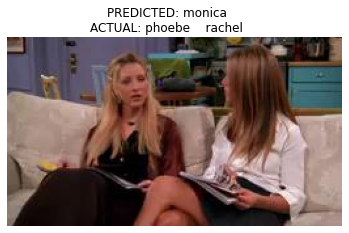

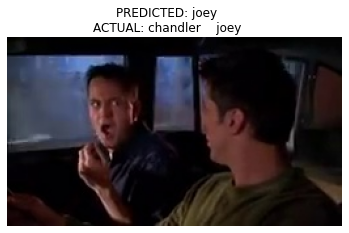

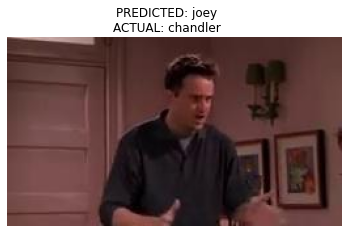

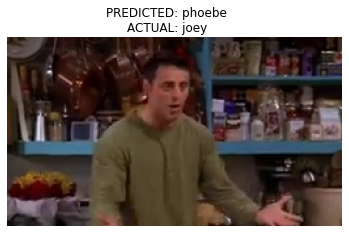

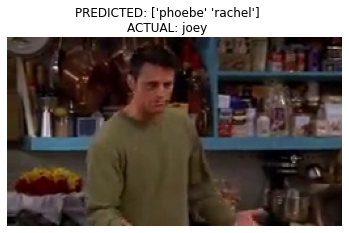

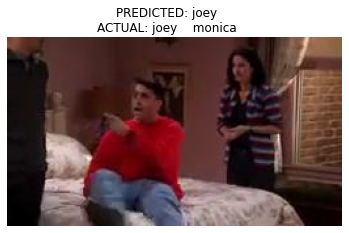

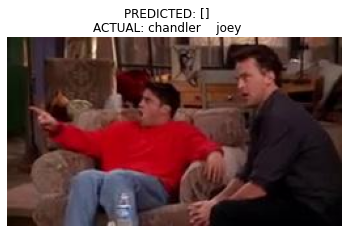

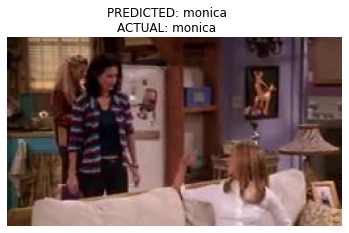

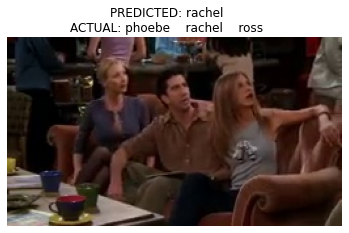

Test Error:  32.4633705337624


In [12]:
model.eval()
test_running_error = 0.0
output_list= []
target_list = []
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    error = get_error( outputs, target, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(target.numpy())
    
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)



In [13]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("f1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

f1 score:  0.23197651663405086
Precision:  0.28493150684931506
Recall:  0.2250228310502283


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For an MLP with one hidden layer of 500 neurons, the below are the results after training for 10 epocs:

* Train Loss: 0.1050
* Train Error:  2.868589828363978
* Val Loss: 0.8828
* Val Error:  30.772570396463077
* We observe that the Train Loss and Train error decreases after each epoch. However, the Validation error may increase or decrease after each epoch (overfitting).
* Test Error:  32.4633705337624
* F1 score:  0.23197651663405086
* Precision:  0.28493150684931506
* Recall:  0.2250228310502283
* The Test error is 32.463% and we have a F1 score of 0.2319
* Learnable Parameters: 55.30 million

## Discussion

A number of factors influence the above results and some of those are,

* The model overfits the data causing fluctuation in the Validation error. If the dataset size is increased or the the network is made deeper or the number of neurons in the hidden layers are increased, then we may expect the results to improve.
* Another reason for overfitting could be the lack of regularization. One could add dropouts or apply image augmentation techniques to prevent the model from overfitting.
* MLP networks do not consider any specific structure of data, and only do pattern matching so they are prone to overfitting.


We try to address some of the above concerns in the MLP improvement discussed next.